[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# 链（Chain）

## 回顾

我们构建了一个包含节点、普通边和条件边的简单图。

## 目标

现在，让我们构建一个结合 4 个概念的简单链（chain）。

* 在图状态中使用[聊天消息](https://docs.langchain.com/oss/python/langchain/messages)
* 在图节点中使用[聊天模型](https://docs.langchain.com/oss/python/integrations/chat)
* 将[工具绑定](https://docs.langchain.com/oss/python/langchain/models#tool-calling)到聊天模型
* 在图节点中[执行工具调用](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop)

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## 消息（Messages）

聊天模型可以使用[消息](https://docs.langchain.com/oss/python/langchain/messages)，它们捕获对话中的不同角色。

LangChain 支持多种消息类型，包括 `HumanMessage`、`AIMessage`、`SystemMessage` 和 `ToolMessage`。

它们分别表示来自用户的消息、来自聊天模型的消息、用于指示模型行为的系统消息，以及来自工具调用的消息。

让我们创建一个消息列表。

每条消息可以包含下列字段：

* `content` —— 消息内容
* `name` —— 可选，消息作者
* `response_metadata` —— 可选，一个元数据字典（例如 `AIMessage` 常由模型提供方填充该字段）

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## 聊天模型（Chat Models）

聊天模型使用一系列消息作为输入，并支持前面讨论的各种消息类型。

有很多可选的模型 [查看选项](https://docs.langchain.com/oss/python/integrations/chat)！这里我们使用 OpenAI 的模型。

下面我们将检查你的 `OPENAI_API_KEY` 是否已设置，如未设置将提示你输入。

In [3]:
import os, getpass
from rich import print as rprint

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置第三方 API Key
_set_env("OPENAI_API_KEY")

# 设置第三方 API Base URL（必需）
# 例如: 
# DeepSeek: https://api.deepseek.com/v1
# 智谱 AI: https://open.bigmodel.cn/api/paas/v4
# 月之暗面 (Kimi): https://api.moonshot.cn/v1
# 阿里云百炼: https://dashscope.aliyuncs.com/compatible-mode/v1
_set_env("OPENAI_API_BASE")

我们可以加载一个聊天模型并用我们的消息列表对其进行调用。

我们可以看到结果是一个带有特定 `response_metadata` 的 `AIMessage`。

In [4]:
from langchain_openai import ChatOpenAI

# 使用环境变量中的配置
# OPENAI_API_KEY 和 OPENAI_API_BASE 会自动从环境变量中读取
dsv3_2_chat = ChatOpenAI(model="deepseek-ai/DeepSeek-V3.2-Exp", temperature=0)
MiniMax_M2_chat = ChatOpenAI(model="MiniMaxAI/MiniMax-M2", temperature=0)

# 注意：请根据你使用的第三方服务修改 model 参数
# 例如：
# DeepSeek: model="deepseek-chat"
# 智谱 AI: model="glm-4"
# 月之暗面: model="moonshot-v1-8k"
# 阿里通义千问: model="qwen-turbo"


result = dsv3_2_chat.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [ ]:
rprint(result)


AIMessage(
    content='Of course! The best place to see orcas in the US is, without a doubt, the **Pacific Northwest**, 
specifically the transboundary waters known as the **Salish Sea**, which includes Washington state and British 
Columbia, Canada.\n\nWithin this region, there are a few standout locations that offer incredible and reliable 
opportunities.\n\n### The Top Spot: San Juan Islands, Washington\n\nThis archipelago is world-renowned for its 
resident orca populations. It\'s the heart of orca territory in the US.\n\n*   **Why it\'s the best:** It\'s home 
to the **Southern Resident Killer Whales** (J, K, and L pods). These fish-eating orcas are often seen in large, 
social family groups, and their movements are closely tied to the migration of Chinook salmon.\n*   **Best 
Viewing:** Lime Kiln Point State Park on San Juan Island is famously called "Whale Watch Park." It\'s one of the 
best places in the world to see orcas from land as they often swim very close to the shoreline.\n*   **How to see 
them:**\n    *   **Boat Tours:** Depart from Friday Harbor (San Juan Island) or Anacortes. Reputable operators work
with researchers and follow strict guidelines to avoid disturbing the whales.\n    *   **Kayaking:** For a more 
intimate (and thrilling) experience, guided kayak tours are available.\n\n---\n\n### Other Excellent Locations in 
the Pacific Northwest\n\nWhile the San Juans are the prime spot, other nearby areas are also fantastic.\n\n1.  
**Anacortes / Whidbey Island, Washington**\n    *   The waters around Deception Pass and the Saratoga Passage are 
common feeding grounds. Tours from Anacortes have a very high success rate.\n\n2.  **Puget Sound, Washington**\n   
*   It\'s not uncommon for orcas, especially the Transient (Bigg\'s) population that hunts marine mammals, to 
travel deep into the sound near Seattle and Tacoma. Seeing orcas with the Seattle skyline in the background is a 
unique experience.\n\n3.  **Vancouver Island, British Columbia (A very close neighbor)**\n    *   While in Canada, 
it\'s worth mentioning that the waters around Victoria and the Gulf Islands are part of the same ecosystem. The 
**Northern Resident Orcas** are frequently seen here, especially around Johnstone Strait and Robson 
Bight.\n\n---\n\n### A Surprising Contender: **Seward, Alaska**\n\nWhile the PNW is famous for its *resident* 
populations, Alaska offers a different but equally spectacular experience.\n\n*   **Why it\'s great:** The waters 
of **Kenai Fjords National Park** are teeming with marine life. Here, you are more likely to see **Transient 
(Bigg\'s) killer whales** and **Offshore orcas**. The groups are often larger, and the backdrop of glaciers and 
mountains is breathtaking.\n*   **Viewing Season:** A bit later than Washington, from May through 
September.\n\n---\n\n### Key Things to Know Before You Go:\n\n*   **Season:** The best time for the Pacific 
Northwest is **May through September**, with peak sightings from June to August.\n*   **Resident vs. Transient:**\n
*   **Residents:** Live in large, stable pods and eat almost exclusively fish (mainly salmon). They are more vocal 
and often travel in larger groups.\n    *   **Transients (Bigg\'s):** Hunt marine mammals (seals, sea lions, 
porpoises). They travel in smaller, quieter groups and their appearances are less predictable but can feature 
dramatic hunting behavior.\n*   **Choose Responsible Tours:** Select operators who support whale research, maintain
a respectful distance, and are certified by organizations like the **Pacific Whale Watch Association 
(PWWA)**.\n\n**In summary: For the classic, family-group orca experience with the highest probability of sightings,
the San Juan Islands, Washington, is your best bet. For a more rugged, Alaskan adventure with stunning scenery, 
consider Seward.**',
    additional_kwargs={'refusal': None},
    response_metadata={
        'token_usage': {
            'completion_tokens': 826,
            'prompt_tokens': 

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 826,
  'prompt_tokens': 56,
  'total_tokens': 882,
  'completion_tokens_details': {'accepted_prediction_tokens': None,
   'audio_tokens': None,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': None},
  'prompt_tokens_details': None},
 'model_provider': 'openai',
 'model_name': 'deepseek-ai/DeepSeek-V3.2-Exp',
 'system_fingerprint': '',
 'id': '019aa0898b3b0fc32605406b1015bc1a',
 'finish_reason': 'stop',
 'logprobs': None}

In [8]:
rprint(result.content)

Of course! The best place to see orcas in the US is, without a doubt, the **Pacific Northwest**, specifically the 
transboundary waters known as the **Salish Sea**, which includes Washington state and British Columbia, Canada.

Within this region, there are a few standout locations that offer incredible and reliable opportunities.

### The Top Spot: San Juan Islands, Washington

This archipelago is world-renowned for its resident orca populations. It's the heart of orca territory in the US.

*   **Why it's the best:** It's home to the **Southern Resident Killer Whales** (J, K, and L pods). These 
fish-eating orcas are often seen in large, social family groups, and their movements are closely tied to the 
migration of Chinook salmon.
*   **Best Viewing:** Lime Kiln Point State Park on San Juan Island is famously called "Whale Watch Park." It's one
of the best places in the world to see orcas from land as they often swim very close to the shoreline.
*   **How to see them:**
    *   **Boat Tours:** Depart from Friday Harbor (San Juan Island) or Anacortes. Reputable operators work with 
researchers and follow strict guidelines to avoid disturbing the whales.
    *   **Kayaking:** For a more intimate (and thrilling) experience, guided kayak tours are available.

---

### Other Excellent Locations in the Pacific Northwest

While the San Juans are the prime spot, other nearby areas are also fantastic.

1.  **Anacortes / Whidbey Island, Washington**
    *   The waters around Deception Pass and the Saratoga Passage are common feeding grounds. Tours from Anacortes 
have a very high success rate.

2.  **Puget Sound, Washington**
    *   It's not uncommon for orcas, especially the Transient (Bigg's) population that hunts marine mammals, to 
travel deep into the sound near Seattle and Tacoma. Seeing orcas with the Seattle skyline in the background is a 
unique experience.

3.  **Vancouver Island, British Columbia (A very close neighbor)**
    *   While in Canada, it's worth mentioning that the waters around Victoria and the Gulf Islands are part of the
same ecosystem. The **Northern Resident Orcas** are frequently seen here, especially around Johnstone Strait and 
Robson Bight.

---

### A Surprising Contender: **Seward, Alaska**

While the PNW is famous for its *resident* populations, Alaska offers a different but equally spectacular 
experience.

*   **Why it's great:** The waters of **Kenai Fjords National Park** are teeming with marine life. Here, you are 
more likely to see **Transient (Bigg's) killer whales** and **Offshore orcas**. The groups are often larger, and 
the backdrop of glaciers and mountains is breathtaking.
*   **Viewing Season:** A bit later than Washington, from May through September.

---

### Key Things to Know Before You Go:

*   **Season:** The best time for the Pacific Northwest is **May through September**, with peak sightings from June
to August.
*   **Resident vs. Transient:**
    *   **Residents:** Live in large, stable pods and eat almost exclusively fish (mainly salmon). They are more 
vocal and often travel in larger groups.
    *   **Transients (Bigg's):** Hunt marine mammals (seals, sea lions, porpoises). They travel in smaller, quieter
groups and their appearances are less predictable but can feature dramatic hunting behavior.
*   **Choose Responsible Tours:** Select operators who support whale research, maintain a respectful distance, and 
are certified by organizations like the **Pacific Whale Watch Association (PWWA)**.

**In summary: For the classic, family-group orca experience with the highest probability of sightings, the San Juan
Islands, Washington, is your best bet. For a more rugged, Alaskan adventure with stunning scenery, consider 
Seward.**

## 工具（Tools）

当你希望模型与外部系统交互时，工具非常有用。

外部系统（例如 API）通常需要特定的输入模式或负载，而不是自然语言。

当我们将一个 API 绑定为工具时，会让模型了解所需的输入模式。

模型会基于用户的自然语言输入决定是否调用工具。

并且，模型会返回符合工具输入/输出模式的结果。

[许多 LLM 提供方支持工具调用](https://docs.langchain.com/oss/python/integrations/chat)，在 LangChain 中[工具调用接口](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/)的使用也很简单。

你可以直接将任何 Python `function` 传入 `ChatModel.bind_tools(function)` 来绑定为工具。

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

下面演示一个简单的工具调用示例！

`multiply` 函数就是我们的工具。

In [10]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = dsv3_2_chat.bind_tools([multiply])

如果我们传入一个输入——例如 `"What is 2 multiplied by 3"`——我们会看到返回了一个工具调用。

该工具调用携带与函数输入模式匹配的具体参数，以及要调用的函数名称。

``` 
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```


In [11]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [12]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': '019aa090fee0371c454fa04402114c99',
  'type': 'tool_call'}]

## 将消息作为状态使用

在具备这些基础之后，我们现在可以在图的状态中使用[消息](https://docs.langchain.com/oss/python/langchain/overview#messages)。

让我们把状态 `MessagesState` 定义为一个只含单键 `messages` 的 `TypedDict`。

`messages` 就是一个消息列表，如上所述（例如 `HumanMessage` 等）。

In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers（归约器）

现在，我们遇到一个小问题！

如前所述，每个节点都会为我们的状态键 `messages` 返回一个新值。

但这个新值会覆盖先前的 `messages` 值！

随着图的运行，我们希望把消息**追加**到 `messages` 状态键中。

我们可以使用[reducer 函数](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers)来解决这个问题。

Reducers 指定了状态更新的方式。

如果没有指定 reducer 函数，则假定对该键的更新应当*覆盖*它（如前所见）。

但要追加消息，我们可以使用预构建的 `add_messages` reducer。

这会确保任何新消息被追加到现有的消息列表中。

我们只需要在 `messages` 键上用 `add_messages` 作为元数据注解即可。

In [16]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

由于在图状态中使用消息列表非常常见，LangGraph 提供了预构建的 [`MessagesState`](https://docs.langchain.com/oss/python/langgraph/graph-api#messagesstate)！

`MessagesState` 的定义：

* 包含预构建的单一 `messages` 键
* 该键是 `AnyMessage` 对象的列表
* 它使用 `add_messages` reducer

我们通常会使用 `MessagesState`，因为它比定义自定义 `TypedDict` 更简洁。

In [17]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

更深入一点，我们可以单独查看 `add_messages` reducer 的工作方式。

In [18]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='3c4f781c-bbbe-4d24-b284-03e6f4024a99'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='c9cc18c6-53df-4e73-a263-a703e5650755'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='6ba6af16-e3ca-4bd8-9b28-d80427adb7a9')]

## 我们的图（Graph）

现在，让我们将 `MessagesState` 与图结合使用。

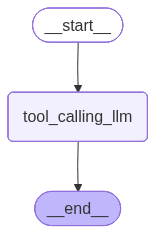

In [20]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

如果我们传入 `Hello!`，LLM 会在没有任何工具调用的情况下进行响应。

In [21]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! I'm here to help you with multiplication calculations. If you have two numbers you'd like to multiply together, just let me know what they are and I can calculate the product for you!


当 LLM 判断输入或任务需要工具提供的功能时，会选择使用工具。

In [22]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

I'll multiply 2 and 3 for you.
Tool Calls:
  multiply (019aa09828ca1ba6527bd95fecc29f93)
 Call ID: 019aa09828ca1ba6527bd95fecc29f93
  Args:
    a: 2
    b: 3
